In [1]:
# utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

# nlp
import nltk
from nltk.corpus import stopwords
import spacy

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# bayes opt
from skopt import BayesSearchCV

# data balancing
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
import random

random.seed(42)

np.random.seed(42)

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("data/2020/fakeWhatsApp.BR_2020_partial.csv")
df = df.dropna(subset=["misinformation"])
print(len(df))
df.head(5)
df = df[["text", "misinformation", "shares"]]
df

1704


text  misinformation  \
0     O ministro da Ciência, Tecnologia, Inovações e...             0.0   
1     Pesquisa com mais de 6.000 médicos em 30 paíse...             1.0   
2     É com muita alegria que comunico que mais um p...             0.0   
3     Renda Brasil unificará vários programas sociai...             0.0   
4     O Secretário-Geral da OTAN Jens Stoltenberg ta...             0.0   
...                                                 ...             ...   
2894  A torcida do corona deve estar arrancando os c...             0.0   
2895  “OS EUA E O CORONAVÍRUS :\r\n\r\nAcabei de ass...             0.0   
2896  Estatísticas falsas conforme depoimentos colhi...             1.0   
2897  Atenção => 🇧🇷💓💓💓 *MUITO IMPORTANTE! "Como é qu...             0.0   
2898  [2:36 PM, 11/06/2020] Wellington: ```*ALERTA A...             1.0   

      shares  
0         27  
1         26  
2         25  
3         25  
4         24  
...      ...  
2894       1  
2895       1  
2896       1  
2897       1  
2898       1  

[1704 rows x 3 columns]

In [5]:
df["cleanLinks"] = df["text"].apply(lambda x: re.split("https:\/\/.*", str(x))[0])

In [6]:
df = df[df["cleanLinks"] != ""]

In [7]:
df.shape

(1390, 4)

data after remove duplicates


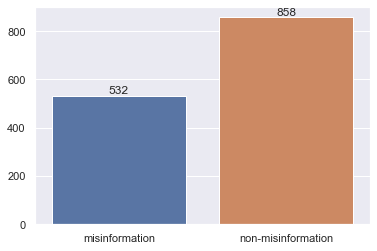

In [8]:
# removing duplicates
df = df.drop_duplicates(subset=["text"])
texts = df["text"]
y = df["misinformation"]

print("data after remove duplicates")
pos_mask = y == 1
pos = y[pos_mask]
neg_mask = y == 0
neg = y[neg_mask]
values = [pos.shape[0], neg.shape[0]]
keys = ["misinformation", "non-misinformation"]
g = sns.barplot(x=keys, y=values)
for p in g.patches:
    g.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

In [9]:
# emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
emojis_list += ["\n"]
punct = list(string.punctuation) + ["\n"]
emojis_punct = emojis_list + punct


def processEmojisPunctuation(text, remove_punct=False, remove_emoji=False):
    """
    Put spaces between emojis. Removes punctuation.
    """
    # get all unique chars
    chars = set(text)
    # for each unique char in text, do:
    for c in chars:

        if remove_punct:  # remove punctuation
            if c in punct:
                text = text.replace(c, " ")
        else:  # put spaces between punctuation
            if c in punct:
                text = text.replace(c, " " + c + " ")

        if remove_emoji:  # remove emojis
            if c in emojis_list:
                text = text.replace(c, " ")
        else:  # put spaces between emojis
            if c in emojis_list:
                text = text.replace(c, " " + c + " ")

    text = re.sub(" +", " ", text)
    return text


# stop words removal
stop_words = list(stopwords.words("portuguese"))
new_stopwords = [
    "aí",
    "pra",
    "vão",
    "vou",
    "onde",
    "lá",
    "aqui",
    "tá",
    "pode",
    "pois",
    "so",
    "deu",
    "agora",
    "todo",
    "nao",
    "ja",
    "vc",
    "bom",
    "ai",
    "ta",
    "voce",
    "alguem",
    "ne",
    "pq",
    "cara",
    "to",
    "mim",
    "la",
    "vcs",
    "tbm",
    "tudo",
]
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = " " + sw + " "
    final_stop_words.append(sw)


def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw, " ")
    text = re.sub(" +", " ", text)
    return text


# lemmatization
nlp = spacy.load("pt_core_news_sm")


def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text


def domainUrl(text):
    """
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    """
    if "http" in text:
        re_url = "[^\s]*https*://[^\s]*"
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split("//")
            domain = domain[1].split("/")[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text


def processLoL(text):
    re_kkk = "kkk*"
    t = re.sub(re_kkk, "kkk", text, flags=re.IGNORECASE)
    return t


def firstSentence(text):
    list_s = re.split("; |\. |\! |\? |\n", text)
    for s in list_s:
        if s is not None:
            return s


def preprocess(text, semi=False, rpunct=False, remoji=False, sentence=False):
    if sentence:
        text = firstSentence(text)  # remove
    text = text.lower().strip()
    text = domainUrl(text)
    text = processLoL(text)
    text = processEmojisPunctuation(text, remove_punct=rpunct, remove_emoji=remoji)
    if semi:
        return text
    text = removeStopwords(text)
    text = lemmatization(text)
    return text

In [10]:
df["text"] = [str(t).strip() for t in df["text"]]

In [11]:
df["pre_processed_text"] = [preprocess(t) for t in texts]
df["semi_processed_text"] = [preprocess(t, semi=True) for t in texts]

In [12]:
def define_vectorizer(experiment):
    max_feat = None
    # maximum number of features
    if "max_features" in experiment:
        max_feat = 5000
    exp_parts = experiment.split("-")
    vec = exp_parts[0]
    ngram = exp_parts[1]
    ng = (1, 1)
    # ngram
    if ngram == "unigram":
        ng = (1, 1)
    elif ngram == "unigram_bigram":
        ng = (1, 2)
    elif ngram == "unigram_bigram_trigram":
        ng = (1, 3)
    # vectorizer
    if vec == "bow":
        vectorizer = CountVectorizer(
            max_features=max_feat,
            binary=True,
            ngram_range=ng,
            lowercase=False,
            token_pattern=r"[^\s]+",
        )
    elif vec == "tfidf":
        vectorizer = TfidfVectorizer(
            max_features=max_feat,
            ngram_range=ng,
            lowercase=False,
            token_pattern=r"[^\s]+",
        )

    return vectorizer


def vectorizing(vectorizer, texts_train, texts_test):
    vectorizer.fit(texts_train)
    X_train = vectorizer.transform(texts_train)
    X_test = vectorizer.transform(texts_test)
    # print('Train:',X_train.shape)
    # print('Test:',X_test.shape)
    return X_train, X_test

In [13]:
def main_framework(X, y, normalization, clf, params, experiment):

    for i in range(42, 46):

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=i, stratify=y
        )

        vectorizer = define_vectorizer(experiment)

        X_train, X_test = vectorizing(vectorizer, X_train, X_test)

        model = Pipeline([("nor", normalization), ("clf", clf)])
        #         model = Pipeline([("clf", clf)])

        opt = BayesSearchCV(model, params, cv=5, scoring="f1")
        opt.fit(X_train, y_train)

        y_pred = opt.predict(X_test)

        print("---------SUMMARY---------")
        print(np.mean(opt.cv_results_["mean_test_score"]))
        
        print("--CLASSIFICATION REPORT--")
        print(metrics.classification_report(y_test, y_pred))
        
        print("----CONFUSION MATRIX----")
        print(metrics.confusion_matrix(y_test, y_pred))
        
        print("-------BEST PARAMS-------")
        print(opt.best_params_)
        print("---------RESULTS---------")

        print("F1-Score: %.4f" % metrics.f1_score(y_test, y_pred))
        print("-------------------------\n")

### bow-unigram_bigram-pre_processed_nb

In [14]:
experiment = "bow-unigram_bigram-pre_processed_nb"

In [15]:
clf = BernoulliNB()

In [16]:
params = {
    "clf__alpha": (1e-6, 1e6, "log-uniform"),
}

In [17]:
X = df["pre_processed_text"]

In [18]:
normalization = MaxAbsScaler()

In [19]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.5515714641403358
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86       172
         1.0       0.90      0.54      0.67       106

    accuracy                           0.80       278
   macro avg       0.84      0.75      0.77       278
weighted avg       0.82      0.80      0.79       278

----CONFUSION MATRIX----
[[166   6]
 [ 49  57]]
-------BEST PARAMS-------
OrderedDict([('clf__alpha', 1.5974202565210027e-06)])
---------RESULTS---------
F1-Score: 0.6746
-------------------------

---------SUMMARY---------
0.5977358354645452
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       172
         1.0       0.88      0.56      0.68       106

    accuracy                           0.80       278
   macro avg       0.83      0.76      0.77       278
weighted avg       0.82      0.80      0.79       278

----CO

### tfidf-unigram_bigram_lsvm

In [20]:
experiment = "tfidf-unigram_bigram_lsvm"

In [21]:
clf = LinearSVC(dual=False)

In [22]:
params = {
    "clf__C": (1e-6, 1e6, "log-uniform"),
}

In [23]:
X = df["semi_processed_text"]

In [24]:
normalization = MaxAbsScaler()

In [25]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.7182568330750084
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85       172
         1.0       0.75      0.80      0.77       106

    accuracy                           0.82       278
   macro avg       0.81      0.82      0.81       278
weighted avg       0.82      0.82      0.82       278

----CONFUSION MATRIX----
[[143  29]
 [ 21  85]]
-------BEST PARAMS-------
OrderedDict([('clf__C', 3.194539027257469)])
---------RESULTS---------
F1-Score: 0.7727
-------------------------

---------SUMMARY---------
0.7243634682717858
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84       172
         1.0       0.73      0.77      0.75       106

    accuracy                           0.80       278
   macro avg       0.79      0.80      0.79       278
weighted avg       0.81      0.80      0.80       278

----CONFUSION M

### bow-unigram_nb

In [26]:
experiment = "bow-unigram_nb"

In [27]:
clf = BernoulliNB()

In [28]:
params = {
    "clf__alpha": (1e-6, 1e6, "log-uniform"),
}

In [29]:
X = df["semi_processed_text"]

In [30]:
normalization = MaxAbsScaler()

In [31]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.5420215093950251
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.78      0.97      0.86       172
         1.0       0.91      0.55      0.68       106

    accuracy                           0.81       278
   macro avg       0.84      0.76      0.77       278
weighted avg       0.83      0.81      0.79       278

----CONFUSION MATRIX----
[[166   6]
 [ 48  58]]
-------BEST PARAMS-------
OrderedDict([('clf__alpha', 1e-06)])
---------RESULTS---------
F1-Score: 0.6824
-------------------------

---------SUMMARY---------
0.5628589585938941
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       172
         1.0       0.84      0.60      0.70       106

    accuracy                           0.81       278
   macro avg       0.82      0.77      0.78       278
weighted avg       0.81      0.81      0.80       278

----CONFUSION MATRIX---

### tfidf-unigram_bigram_trigram_sgd

In [32]:
experiment = "tfidf-unigram_bigram_trigram_sgd"

In [33]:
clf = SGDClassifier()

In [34]:
params = {
    "clf__alpha": (1e-6, 1e6, "log-uniform"),
}

In [35]:
X = df["semi_processed_text"]

In [36]:
normalization = MaxAbsScaler()

In [37]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.6749791916695836
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       172
         1.0       0.77      0.81      0.79       106

    accuracy                           0.83       278
   macro avg       0.82      0.83      0.83       278
weighted avg       0.84      0.83      0.84       278

----CONFUSION MATRIX----
[[146  26]
 [ 20  86]]
-------BEST PARAMS-------
OrderedDict([('clf__alpha', 0.0026013141963243994)])
---------RESULTS---------
F1-Score: 0.7890
-------------------------

---------SUMMARY---------
0.6296465112947902
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       172
         1.0       0.73      0.78      0.75       106

    accuracy                           0.81       278
   macro avg       0.79      0.80      0.80       278
weighted avg       0.81      0.81      0.81       278

----CON

### bow-unigram_bigram_trigram-pre_processed_nb

In [38]:
experiment = "bow-unigram_bigram_trigram-pre_processed_nb"

In [39]:
clf = BernoulliNB()

In [40]:
params = {
    "clf__alpha": (1e-6, 1e6, "log-uniform"),
}

In [41]:
X = df["pre_processed_text"]

In [42]:
normalization = MaxAbsScaler()

In [43]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.537339810123162
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.74      0.97      0.84       172
         1.0       0.91      0.45      0.60       106

    accuracy                           0.77       278
   macro avg       0.82      0.71      0.72       278
weighted avg       0.80      0.77      0.75       278

----CONFUSION MATRIX----
[[167   5]
 [ 58  48]]
-------BEST PARAMS-------
OrderedDict([('clf__alpha', 1e-06)])
---------RESULTS---------
F1-Score: 0.6038
-------------------------

---------SUMMARY---------
0.5887160954090092
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.76      0.95      0.85       172
         1.0       0.87      0.51      0.64       106

    accuracy                           0.78       278
   macro avg       0.82      0.73      0.74       278
weighted avg       0.80      0.78      0.77       278

----CONFUSION MATRIX----

### bow-unigram-pre_processed_nb

In [44]:
experiment = "bow-unigram-pre_processed_nb"

In [45]:
clf = BernoulliNB()

In [46]:
params = {
    "clf__alpha": (1e-6, 1e6, "log-uniform"),
}

In [47]:
X = df["pre_processed_text"]

In [48]:
normalization = MaxAbsScaler()

In [49]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.5666480754659386
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.77      0.96      0.86       172
         1.0       0.89      0.55      0.68       106

    accuracy                           0.80       278
   macro avg       0.83      0.75      0.77       278
weighted avg       0.82      0.80      0.79       278

----CONFUSION MATRIX----
[[165   7]
 [ 48  58]]
-------BEST PARAMS-------
OrderedDict([('clf__alpha', 1e-06)])
---------RESULTS---------
F1-Score: 0.6784
-------------------------

---------SUMMARY---------
0.6134834958071476
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84       172
         1.0       0.81      0.56      0.66       106

    accuracy                           0.78       278
   macro avg       0.79      0.74      0.75       278
weighted avg       0.79      0.78      0.77       278

----CONFUSION MATRIX---

### tfidf-unigram_bigram_trigram-pre_processed_sgd

In [50]:
experiment = "tfidf-unigram_bigram_trigram-pre_processed_sgd"

In [51]:
clf = SGDClassifier()

In [52]:
params = {
    "clf__alpha": (1e-6, 1e6, "log-uniform"),
}

In [53]:
X = df["pre_processed_text"]

In [54]:
normalization = MaxAbsScaler()

In [55]:
main_framework(X, y, normalization, clf, params, experiment)

---------SUMMARY---------
0.6820411625538714
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       172
         1.0       0.78      0.83      0.80       106

    accuracy                           0.85       278
   macro avg       0.83      0.84      0.84       278
weighted avg       0.85      0.85      0.85       278

----CONFUSION MATRIX----
[[147  25]
 [ 18  88]]
-------BEST PARAMS-------
OrderedDict([('clf__alpha', 0.002415731439035703)])
---------RESULTS---------
F1-Score: 0.8037
-------------------------

---------SUMMARY---------
0.6857674738258378
--CLASSIFICATION REPORT--
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       172
         1.0       0.76      0.79      0.78       106

    accuracy                           0.83       278
   macro avg       0.82      0.82      0.82       278
weighted avg       0.83      0.83      0.83       278

----CONF